# Exploratory Data Analysis (EDA)

In [1]:
import numpy as np
import pandas as pd
import matplotlib

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import PolynomialFeatures

import os
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
risks = pd.read_csv("/kaggle/input/mai-ml-lab-1-fiit-2025/ex.csv")

In [3]:
train = pd.read_csv("/kaggle/input/mai-ml-lab-1-fiit-2025/train.csv")
test = pd.read_csv("/kaggle/input/mai-ml-lab-1-fiit-2025/test.csv")

In [4]:
train.shape

(11017, 35)

In [5]:
train.dtypes

ApplicationDate                object
Age                           float64
AnnualIncome                  float64
CreditScore                   float64
LoanAmount                    float64
LoanDuration                  float64
MaritalStatus                  object
NumberOfDependents            float64
HomeOwnershipStatus            object
MonthlyDebtPayments           float64
CreditCardUtilizationRate     float64
NumberOfOpenCreditLines       float64
NumberOfCreditInquiries       float64
DebtToIncomeRatio             float64
BankruptcyHistory             float64
LoanPurpose                    object
PreviousLoanDefaults          float64
PaymentHistory                float64
LengthOfCreditHistory         float64
SavingsAccountBalance         float64
CheckingAccountBalance        float64
TotalAssets                   float64
TotalLiabilities              float64
MonthlyIncome                 float64
UtilityBillsPaymentHistory    float64
JobTenure                     float64
EmploymentSt

In [6]:
train_ohe = pd.get_dummies(train.drop('ApplicationDate', axis=1))
test_ohe = pd.get_dummies(test.drop('ApplicationDate', axis=1))

In [7]:
train_ohe.dtypes

Age                               float64
AnnualIncome                      float64
CreditScore                       float64
LoanAmount                        float64
LoanDuration                      float64
NumberOfDependents                float64
MonthlyDebtPayments               float64
CreditCardUtilizationRate         float64
NumberOfOpenCreditLines           float64
NumberOfCreditInquiries           float64
DebtToIncomeRatio                 float64
BankruptcyHistory                 float64
PreviousLoanDefaults              float64
PaymentHistory                    float64
LengthOfCreditHistory             float64
SavingsAccountBalance             float64
CheckingAccountBalance            float64
TotalAssets                       float64
TotalLiabilities                  float64
MonthlyIncome                     float64
UtilityBillsPaymentHistory        float64
JobTenure                         float64
Experience                        float64
NetWorth                          

In [8]:
test_ids = test['ID']

In [9]:
train.isnull().sum()

ApplicationDate                530
Age                            530
AnnualIncome                   530
CreditScore                   1031
LoanAmount                    1031
LoanDuration                   530
MaritalStatus                  530
NumberOfDependents             530
HomeOwnershipStatus            530
MonthlyDebtPayments           1031
CreditCardUtilizationRate      530
NumberOfOpenCreditLines        530
NumberOfCreditInquiries        530
DebtToIncomeRatio              530
BankruptcyHistory             1031
LoanPurpose                   1031
PreviousLoanDefaults           530
PaymentHistory                 530
LengthOfCreditHistory          530
SavingsAccountBalance          530
CheckingAccountBalance        1031
TotalAssets                   1031
TotalLiabilities               530
MonthlyIncome                  530
UtilityBillsPaymentHistory     530
JobTenure                      530
EmploymentStatus               530
EducationLevel                 530
Experience          

In [10]:
train.duplicated().sum()

1016

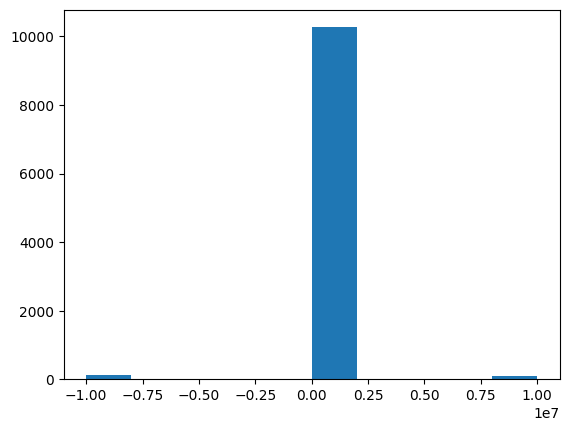

In [11]:
plt.hist(train['RiskScore'].dropna())
plt.show()

{'whiskers': [<matplotlib.lines.Line2D at 0x7e18009a5490>,
 'caps': [<matplotlib.lines.Line2D at 0x7e180083e190>,
 'boxes': [<matplotlib.lines.Line2D at 0x7e1800a2bcd0>],
 'medians': [<matplotlib.lines.Line2D at 0x7e180083f850>],
 'fliers': [<matplotlib.lines.Line2D at 0x7e18008482d0>],
 'means': []}

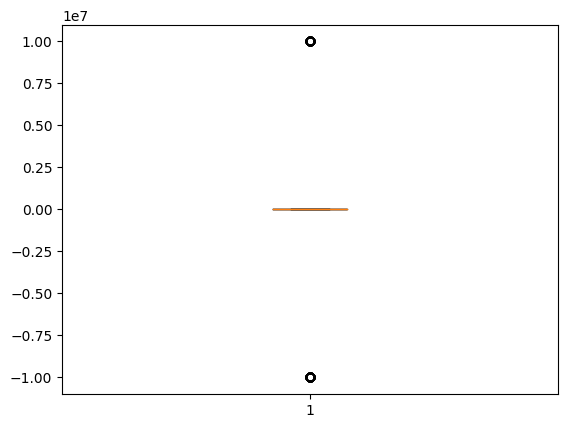

In [12]:
plt.boxplot(train['RiskScore'].dropna())

In [13]:
clear_risks = pd.DataFrame()
clear_risks['RiskScore'] = train['RiskScore'].dropna()

In [14]:
clear_risks.describe()

,RiskScore
count,1.048700e+04
mean,-2.569878e+04
std,1.431675e+06
min,-9.999999e+06
25%,3.256475e+01
50%,4.411876e+01
75%,6.535690e+01
max,1.000000e+07


In [15]:
def normalize_z_score(x: pd.Series):
    if isinstance(x, pd.Series):
        std = x.std()
        if np.isnan(std) or std == 0:
            return pd.Series(np.zeros(len(x)), index=x.index)
        
        z_scores = (x - x.mean()) / std
        z_scores = z_scores.replace([np.inf, -np.inf], np.nan)
        return z_scores
    elif isinstance(x, pd.DataFrame):
        return x.apply(normalize_z_score)
    
def normalize_min_max(x: pd.Series):
    mn = x.min()
    mx = x.max()

    return (x - mn) / (mx - mn)

In [16]:
def remove_outliers_z(data: pd.DataFrame, column=None, threshold=5):
    if column is None:
        outliers = normalize_z_score(data).abs() > threshold
    else:
        outliers = normalize_z_score(data[column]).abs() > threshold
    
    return data[~outliers]

def fill_missing_values(df):
    df_filled = df.copy()
    numeric_cols = df_filled.select_dtypes(include=[np.number]).columns
    numeric_cols = [col for col in numeric_cols if col != 'RiskScore']
    
    for col in numeric_cols:
        if df_filled[col].isnull().any():
            df_filled[col] = df_filled[col].fillna(df_filled[col].median())
            
    categorical_cols = df_filled.select_dtypes(include=['object', 'category']).columns
    for col in categorical_cols:
        if df_filled[col].isnull().any():
            mode_value = df_filled[col].mode()[0] if not df_filled[col].mode().empty else 'Unknown'
            df_filled[col] = df_filled[col].fillna(mode_value)
    return df_filled

In [17]:
normalized_risks = remove_outliers_z(clear_risks, 'RiskScore')

<Axes: >

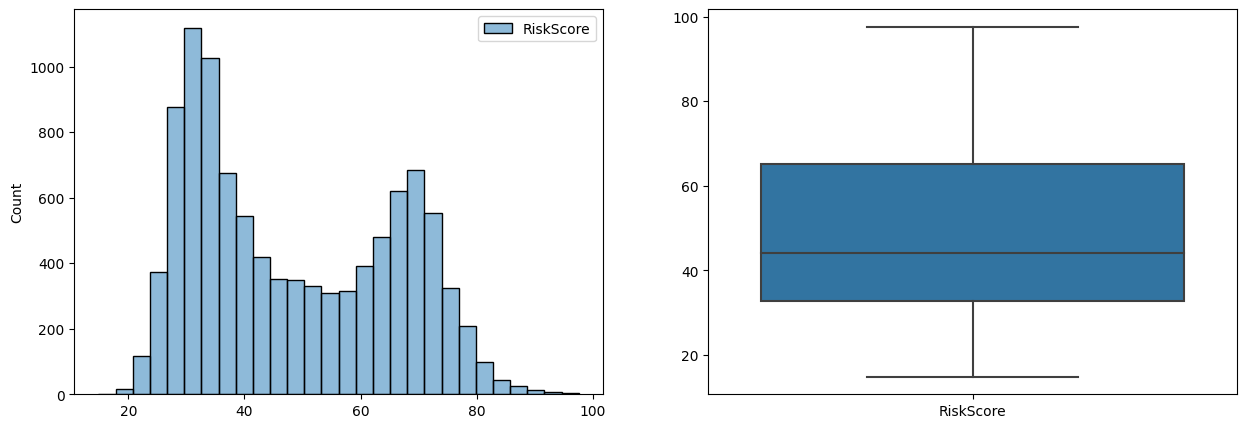

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(normalized_risks, ax=ax[0])
sns.boxplot(normalized_risks, ax=ax[1])

<Axes: ylabel='Count'>

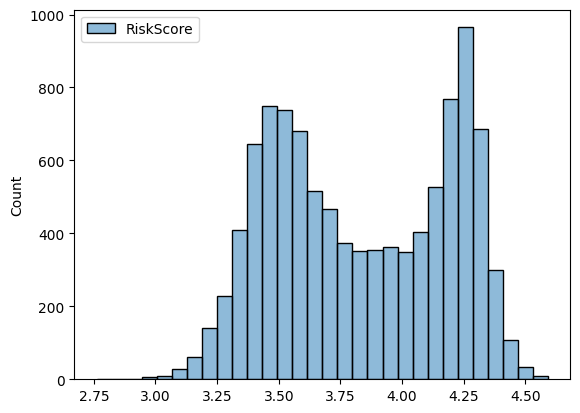

In [19]:
sns.histplot(np.log1p(normalized_risks))

In [20]:
train_clean = remove_outliers_z(train_ohe, threshold=6)

train_clean = train_clean.dropna(subset=['RiskScore'])
train_clean = fill_missing_values(train_clean)

test_clean = fill_missing_values(test_ohe)

/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


In [21]:
train_clean

,Age,AnnualIncome,CreditScore,LoanAmount,LoanDuration,NumberOfDependents,MonthlyDebtPayments,CreditCardUtilizationRate,NumberOfOpenCreditLines,NumberOfCreditInquiries,...,LoanPurpose_Home,LoanPurpose_Other,EmploymentStatus_Employed,EmploymentStatus_Self-Employed,EmploymentStatus_Unemployed,EducationLevel_Associate,EducationLevel_Bachelor,EducationLevel_Doctorate,EducationLevel_High School,EducationLevel_Master
0,27.0,66829.0,549.0,17290.0,60.0,1.0,1095.0,0.151985,2.0,1.0,...,False,False,True,False,False,True,False,False,False,False
1,55.0,172147.0,850.0,16110.0,36.0,1.0,211.0,0.175693,3.0,0.0,...,True,False,True,False,False,False,False,False,True,False
2,51.0,300000.0,850.0,38436.0,36.0,0.0,546.0,0.444605,3.0,0.0,...,False,False,True,False,False,False,True,False,False,False
3,25.0,34683.0,847.0,19186.0,48.0,0.0,153.0,0.188452,7.0,0.0,...,False,False,True,False,False,False,False,False,True,False
4,55.0,300000.0,850.0,30437.0,48.0,2.0,562.0,0.273431,3.0,1.0,...,False,False,True,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11011,39.0,300000.0,850.0,7721.0,72.0,5.0,276.0,0.215136,2.0,1.0,...,True,False,True,False,False,True,False,False,False,False
11012,57.0,300000.0,850.0,14756.0,48.0,2.0,620.0,0.477742,1.0,3.0,...,False,False,True,False,False,True,False,False,False,False
11013,28.0,15000.0,300.0,51361.0,96.0,1.0,696.0,0.322554,2.0,0.0,...,True,False,True,False,False,False,True,False,False,False
11014,23.0,15000.0,302.0,30724.0,72.0,3.0,413.0,0.497062,2.0,0.0,...,False,False,False,True,False,True,False,False,False,False


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


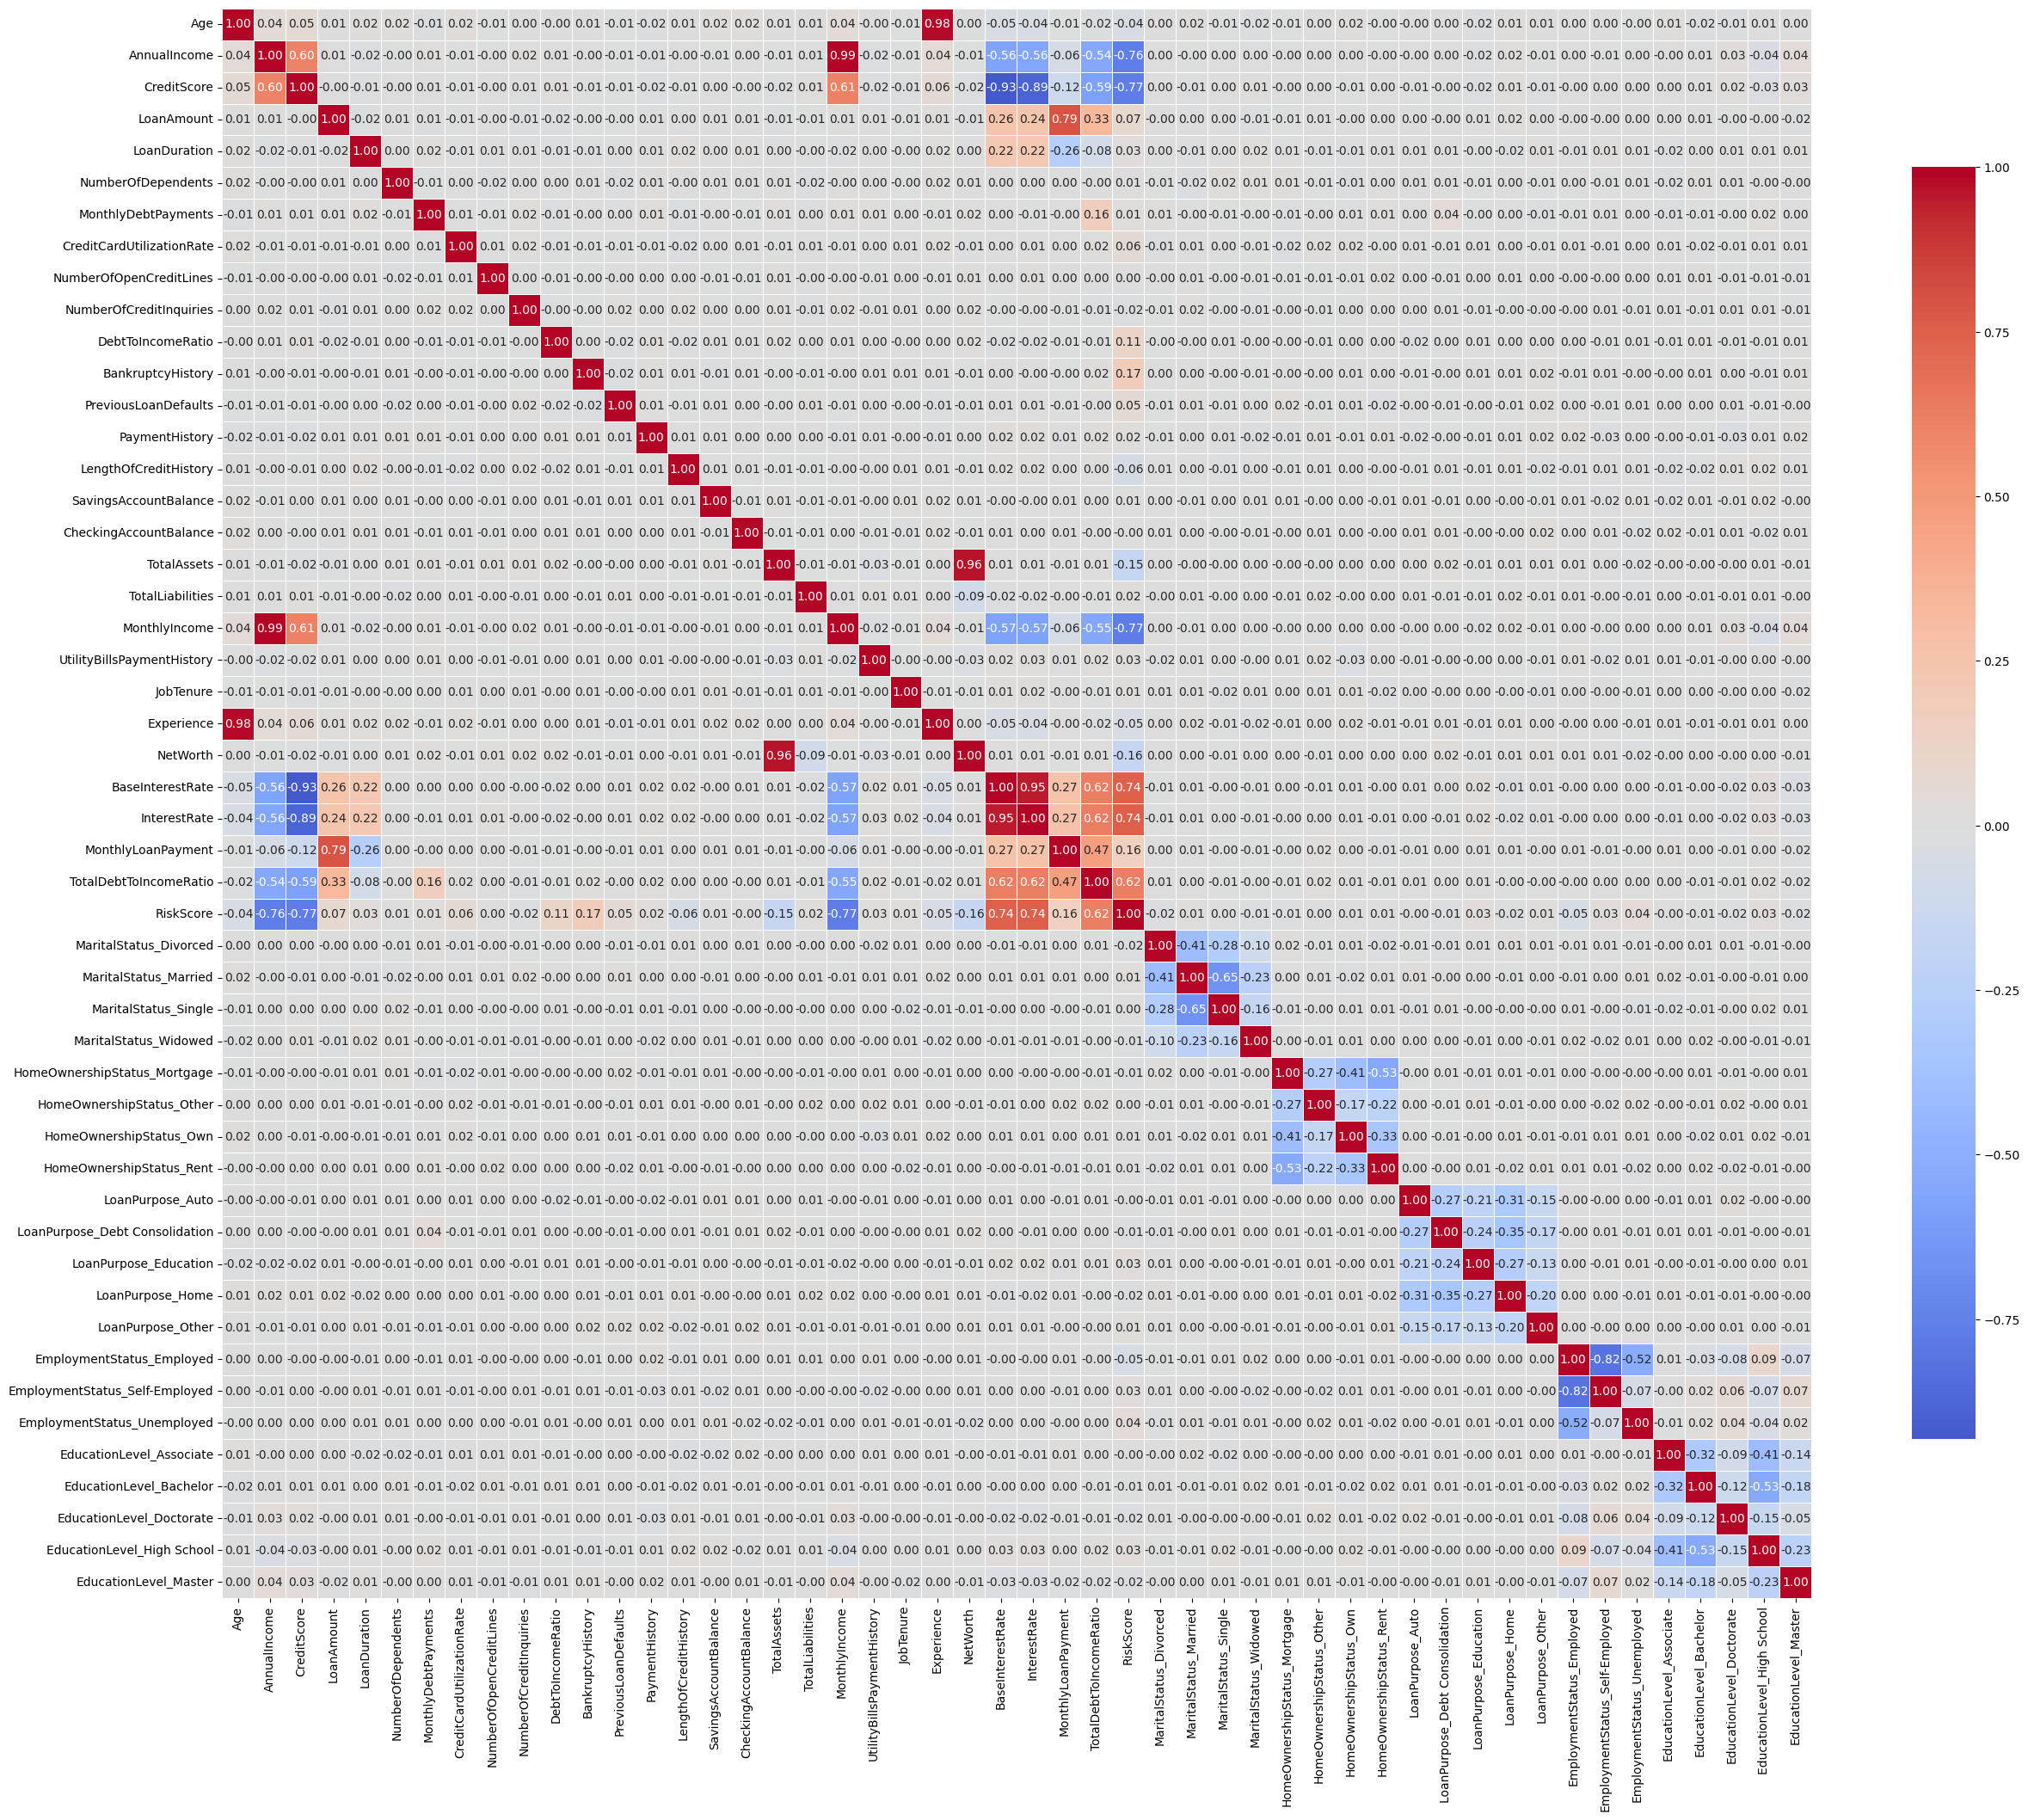

In [22]:
correlation_matrix = train_clean.corr()

plt.figure(figsize=(30, 24))

sns.heatmap(correlation_matrix, 
            annot=True,           
            cmap='coolwarm',      
            center=0,             
            fmt='.2f',            
            square=True,          
            linewidths=0.5,       
            cbar_kws={'shrink': 0.8})

plt.show()

In [23]:
corr_matrix = correlation_matrix.copy()
np.fill_diagonal(corr_matrix.values, 0)

corr_pairs = corr_matrix.stack().reset_index()
corr_pairs.columns = ['Признак_1', 'Признак_2', 'Корреляция']

corr_pairs = corr_pairs[corr_pairs['Признак_1'] < corr_pairs['Признак_2']]

corr_pairs['|Корреляция|'] = corr_pairs['Корреляция'].abs()
corr_pairs = corr_pairs.sort_values(by='|Корреляция|', ascending=False)

top_correlations = corr_pairs.head(20)
print('Top correlations:\n')
print(top_correlations[['Признак_1', 'Признак_2', 'Корреляция']])
print('\nRisk Score correlations:\n')
print(corr_pairs.loc[(corr_pairs['Признак_2'] == 'RiskScore') | (corr_pairs['Признак_1'] == 'RiskScore'), ['Признак_1', 'Признак_2', 'Корреляция']])

Top correlations:

                      Признак_1                       Признак_2  Корреляция
69                 AnnualIncome                   MonthlyIncome    0.985438
22                          Age                      Experience    0.982964
1167                   NetWorth                     TotalAssets    0.963830
1225           BaseInterestRate                    InterestRate    0.947841
1202           BaseInterestRate                     CreditScore   -0.931665
125                 CreditScore                    InterestRate   -0.886032
2143  EmploymentStatus_Employed  EmploymentStatus_Self-Employed   -0.815111
176                  LoanAmount              MonthlyLoanPayment    0.790331
978               MonthlyIncome                       RiskScore   -0.770267
128                 CreditScore                       RiskScore   -0.766043
78                 AnnualIncome                       RiskScore   -0.758514
1278               InterestRate                       RiskScore    0.

#### Обратим внимание, что Net Worth и Total Assets, Age и Experience, AnnualIncome и MonthIncome, BaseInterestRate и InterestRate сильно коррелируют, следовательно, можно взять в качестве признаков только те значения из каждой пары, которые будут иметь наибольшую корреляцию с Risk Score.

In [24]:
train_clean.loc[train_clean['EducationLevel_Master'], 'RiskScore']

38       83.343356
67       75.470043
69       33.124091
70       31.435646
74       27.925237
           ...    
10925    73.218318
10958    60.461255
10987    30.258943
10993    34.483793
11008    42.571654
Name: RiskScore, Length: 738, dtype: float64

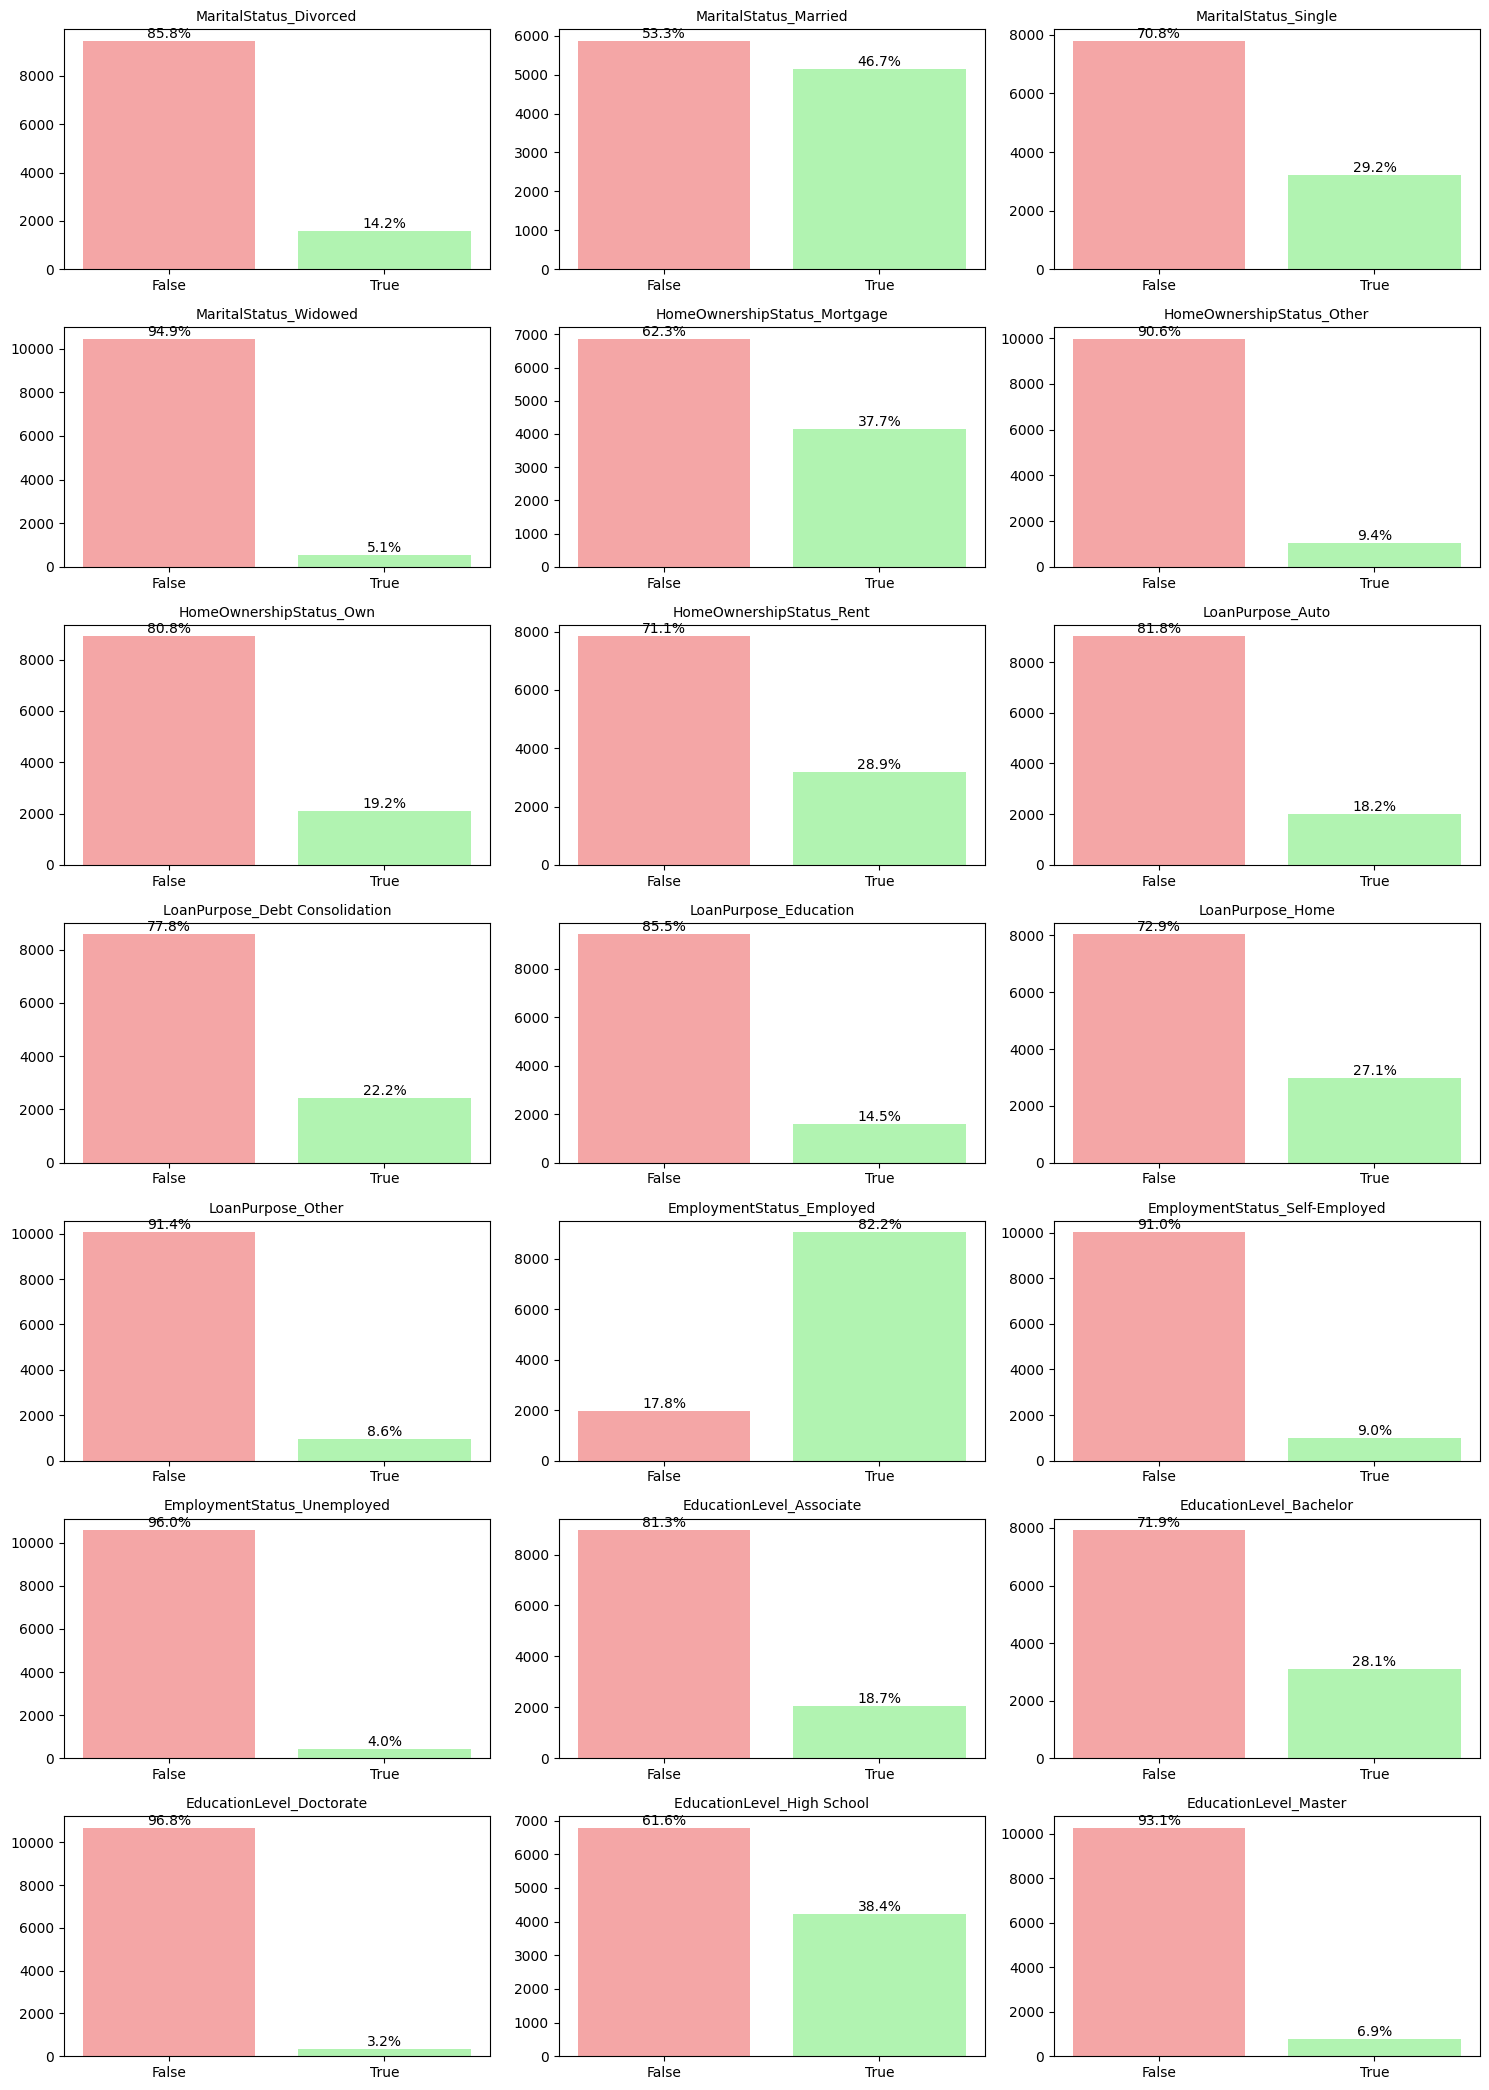

In [25]:
categorical_columns = train_ohe.select_dtypes(include=['bool']).columns

_, axes = plt.subplots((len(categorical_columns) + 2) // 3, 3, figsize=(15, 3 * ((len(categorical_columns) + 2) // 3)))
axes = axes.flatten()

for i, col in enumerate(categorical_columns):
    value_counts = train_ohe[col].value_counts()
    bars = axes[i].bar(['False', 'True'], [value_counts.get(False, 0), value_counts.get(True, 0)], 
                      color=['lightcoral', 'lightgreen'], alpha=0.7)
    axes[i].set_title(col, fontsize=10)
    
    total = len(train_ohe[col])
    for j, count in enumerate([value_counts.get(False, 0), value_counts.get(True, 0)]):
        axes[i].text(j, count, f'{100 * count / total:.1f}%', ha='center', va='bottom')

for i in range(len(categorical_columns), len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()

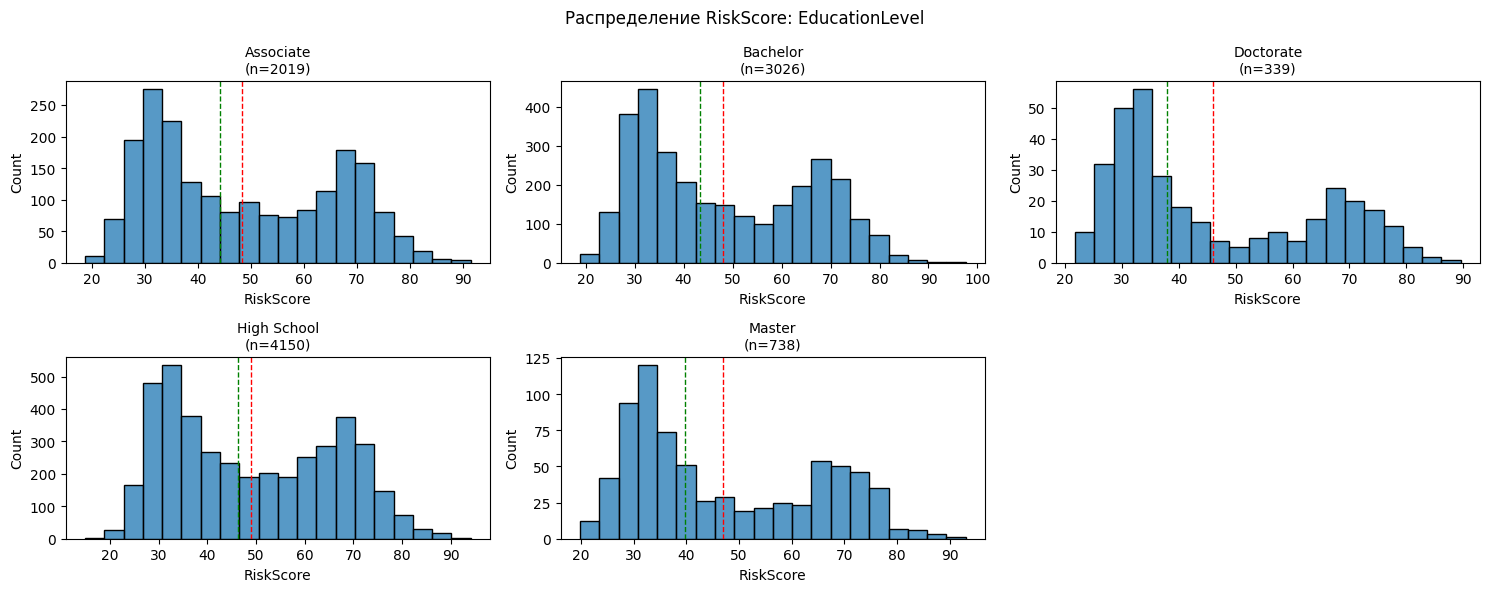

Категория с наименьшим средним RiskScore: Doctorate (46.1)
Категория с наибольшим средним RiskScore: High School (49.0)

Категория с наименьшей медианой RiskScore: Doctorate (37.9)
Категория с наибольшей медианой RiskScore: High School (46.4)


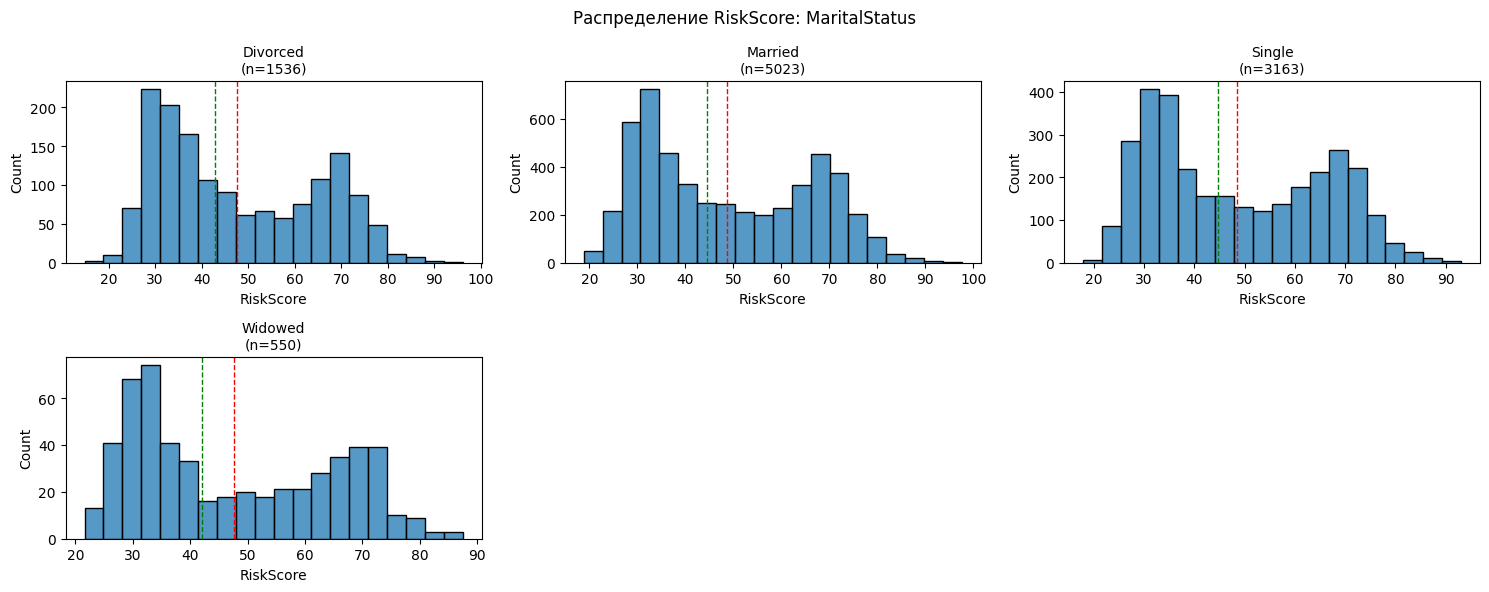

Категория с наименьшим средним RiskScore: Widowed (47.5)
Категория с наибольшим средним RiskScore: Married (48.6)

Категория с наименьшей медианой RiskScore: Widowed (42.1)
Категория с наибольшей медианой RiskScore: Single (44.8)


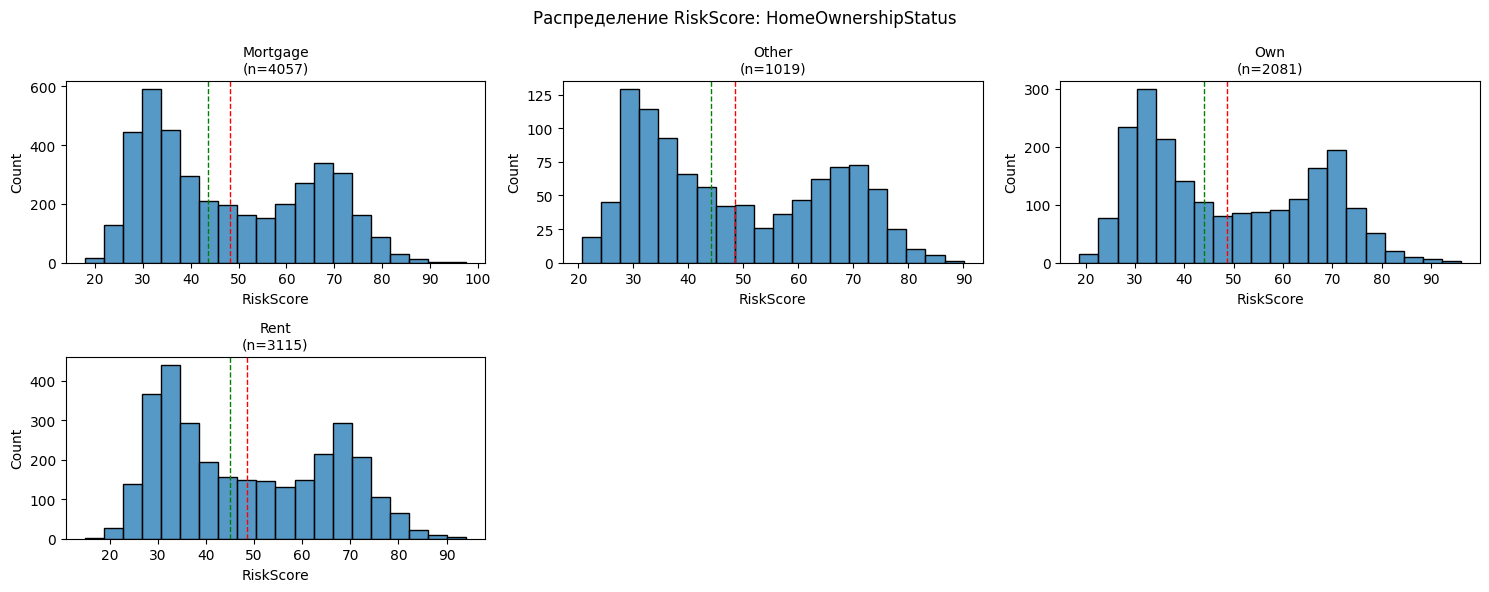

Категория с наименьшим средним RiskScore: Mortgage (48.1)
Категория с наибольшим средним RiskScore: Own (48.6)

Категория с наименьшей медианой RiskScore: Mortgage (43.7)
Категория с наибольшей медианой RiskScore: Rent (45.1)


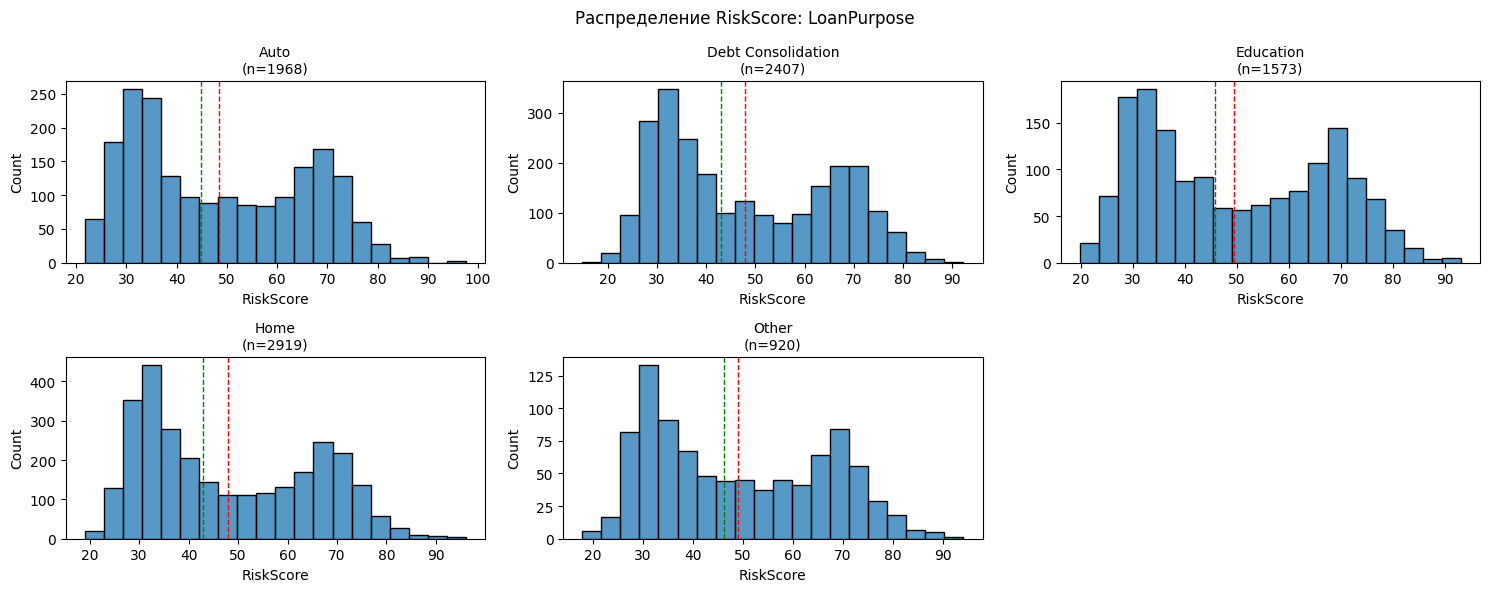

Категория с наименьшим средним RiskScore: Home (47.9)
Категория с наибольшим средним RiskScore: Education (49.5)

Категория с наименьшей медианой RiskScore: Home (42.8)
Категория с наибольшей медианой RiskScore: Other (46.3)


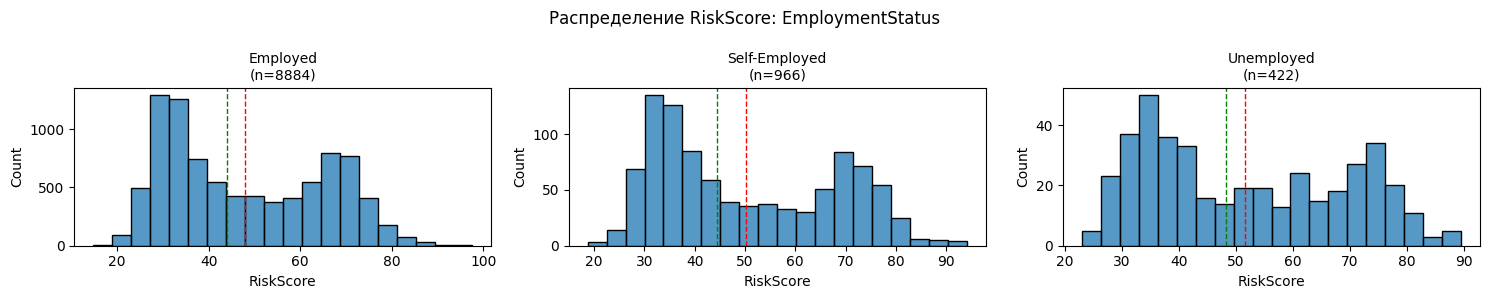

Категория с наименьшим средним RiskScore: Employed (48.0)
Категория с наибольшим средним RiskScore: Unemployed (51.6)

Категория с наименьшей медианой RiskScore: Employed (44.0)
Категория с наибольшей медианой RiskScore: Unemployed (48.3)


In [26]:
categorical_features = ['EducationLevel', 'MaritalStatus', 'HomeOwnershipStatus', 'LoanPurpose', 'EmploymentStatus']

common_indices = train_clean.index.intersection(train.index)

for feature in categorical_features:
    columns = [col for col in train_clean.columns if feature in col]
    if not columns:
        continue
    
    n_cols = len(columns)
    n_rows = (n_cols + 2) // 3
    fig, axes = plt.subplots(n_rows, 3, figsize=(15, 3 * n_rows))
    
    if n_rows > 1:
        axes = axes.flatten()
    else:
        axes = axes if isinstance(axes, np.ndarray) else [axes]
    
    stats_mean = []
    stats_median = []
    for i, col in enumerate(columns):
        category_name = col.replace(feature + '_', '')
        mask = train_clean.loc[common_indices, col] == True
        category_data = train.loc[common_indices[mask], 'RiskScore'].dropna()
        
        sns.histplot(category_data, bins=20, ax=axes[i], kde=False)
        axes[i].set_title(f'{category_name}\n(n={len(category_data)})', fontsize=10)
        axes[i].axvline(category_data.median(), color='green', linestyle='--', linewidth=1)
        axes[i].axvline(category_data.mean(), color='red', linestyle='--', linewidth=1)
        
        if len(category_data) > 0:
            stats_mean.append((category_name, category_data.mean()))
            stats_median.append((category_name, category_data.median()))
    
    for i in range(len(columns), len(axes)):
        axes[i].set_visible(False)
    
    plt.suptitle(f'Распределение RiskScore: {feature}')
    plt.tight_layout()
    plt.show()
    
    if stats_mean and stats_median:
        stats_mean.sort(key=lambda x: x[1])
        stats_median.sort(key=lambda x: x[1])
        print(f"Категория с наименьшим средним RiskScore: {stats_mean[0][0]} ({stats_mean[0][1]:.1f})")
        print(f"Категория с наибольшим средним RiskScore: {stats_mean[-1][0]} ({stats_mean[-1][1]:.1f})")
        print()
        print(f"Категория с наименьшей медианой RiskScore: {stats_median[0][0]} ({stats_median[0][1]:.1f})")
        print(f"Категория с наибольшей медианой RiskScore: {stats_median[-1][0]} ({stats_median[-1][1]:.1f})")

#### В качестве признаков возьмем:
CreditScore, MonthlyIncome, BaseInterestRate, TotalDebtToIncomeRatio, BankruptcyHistory, MonthlyLoanPayment, TotalAssets, DebtToIncomeRatio, LoanAmount, LengthOfCreditHistory, CreditCardUtilizationRate, PreviousLoanDefaults, EmploymentStatus_Employed, Experience, EmploymentStatus_Unemployed, LoanPurpose_Education, LoanPurpose_Home, EducationLevel_Doctorate, EducationLevel_High School

# Линейная регрессия

In [27]:
import random

from abc import ABC, abstractmethod
from sklearn.linear_model import LinearRegression as SkLinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

In [28]:
class Metric(ABC):
    @abstractmethod
    def score(self, y: np.array, y_pred: np.array):
        pass

class TrainingMetric(Metric):
    @abstractmethod
    def gradient(self, X: np.array, y: np.array, y_pred: np.array):
        pass

class MSE(TrainingMetric):
    def score(self, y: np.array, y_pred: np.array):
        return np.sum((y_pred - y) ** 2) / y.shape[0]

    def gradient(self, X: np.array, y: np.array, y_pred: np.array):
        return 2 * X.T.dot(y_pred - y) / y.shape[0]

class MAE(TrainingMetric):
    def score(self, y: np.array, y_pred: np.array):
        return np.sum(np.abs(y_pred - y)) / y.shape[0]

    def gradient(self, X: np.array, y: np.array, y_pred: np.array):
        return X.T.dot(np.sign(y_pred - y)) / y.shape[0]
        
class MAPE(Metric):
    def score(self, y: np.array, y_pred: np.array):
        return np.mean(np.abs((y - y_pred) / y))

class R2(Metric):
    def score(self, y: np.array, y_pred: np.array):
        sq_sum = np.sum((y - y_pred) ** 2)
        sq_mean_sum = np.sum((y - y.mean()) ** 2)
        
        return 1 - (sq_sum) / (sq_mean_sum)

In [29]:
class Solver(ABC):
    def __init__(self):
        pass

    @abstractmethod
    def solve(self, X: np.array, y: np.array):
        pass

class ExactSolver(Solver):
    def __init__(self, alpha=0.5): 
        self.alpha = alpha

    def solve(self, X: np.array, y: np.array):
        n_features = X.shape[1]
        I = np.eye(n_features)
        I[0, 0] = 0
        
        try:
            weights = np.linalg.inv(X.T @ X + self.alpha * I) @ X.T @ y
        except np.linalg.LinAlgError:
            weights = np.linalg.pinv(X.T @ X + self.alpha * I) @ X.T @ y
            
        return weights, [0]

class GDSolver(Solver):
    def __init__(self, learning_rate=0.25, lr_update='constant', metric=MSE(), 
                 epsilon=10e-12, n_iters=100_000, regularization=None, 
                 alpha=1.0, l1_ratio=0.3, p=1.0):
        self.learning_rate = learning_rate
        self.lr_update = lr_update
        self.metric = metric
        self.epsilon = epsilon
        self.n_iters = n_iters
        self.regularization = regularization
        self.alpha = alpha
        self.l1_ratio = l1_ratio
        self.p = p
        
    def _compute_regularization_weight(self, weights):
        if not self.regularization:
            return 0
            
        match self.regularization:
            case 'Lp':
                abs_weights = np.abs(weights)
                return np.sum(abs_weights ** self.p)
            case 'ElasticNet':
                l1_component = np.sum(np.abs(weights))
                l2_component = np.sum(weights ** 2)
                return self.l1_ratio * l1_component + (1 - self.l1_ratio) * l2_component
        return 0
    
    def _compute_regularization_gradient(self, weights):
        if not self.regularization:
            return np.zeros_like(weights)
            
        match self.regularization:
            case 'Lp':
                abs_weights = np.abs(weights)
                reg_gradient = self.p * np.sign(weights) * (abs_weights ** (self.p - 1))
                return np.where(abs_weights < 1e-8, 0, reg_gradient)
            case 'ElasticNet':
                return (self.l1_ratio * np.sign(weights) + 
                       2 * (1 - self.l1_ratio) * weights)
        return np.zeros_like(weights)
        
    def solve(self, X: np.array, y: np.array):
        weights = np.zeros(X.shape[1])
        last_loss = 0
        loss = 1
        loss_history = []
        update_interval = 1000
        reduce_factor = 10
        i = 0

        while (abs(loss - last_loss) >= self.epsilon and i < self.n_iters):
            i += 1
            last_loss = loss
            
            y_pred = X.dot(weights)
            error = y - y_pred

            regularization_weight = self._compute_regularization_weight(weights)
            loss = self.metric.score(y, y_pred) + self.alpha * regularization_weight
            loss_history.append(loss)

            gradient = self.metric.gradient(X, y, y_pred)
            
            reg_gradient = self._compute_regularization_gradient(weights)
            gradient += self.alpha * reg_gradient

            weights = weights - self.learning_rate * gradient

            if (i % update_interval == 0 and self.learning_rate > self.epsilon):
                match (self.lr_update):
                    case 'reducing':
                        self.learning_rate /= reduce_factor
                        update_interval *= reduce_factor

        return weights, loss_history


class SGDSolver(Solver):
    def __init__(self, learning_rate=0.25, lr_update='constant', metric=MSE(), 
                 n_epochs=500, batch_size=1, epsilon=1e-6, regularization=None, 
                 alpha=1.0, l1_ratio=0.3, p=1.0):
        self.learning_rate = learning_rate
        self.initial_learning_rate = learning_rate
        self.lr_update = lr_update
        self.metric = metric
        self.n_epochs = n_epochs
        self.batch_size = batch_size
        self.epsilon = epsilon
        self.regularization = regularization
        self.alpha = alpha
        self.l1_ratio = l1_ratio
        self.p = p
    
    def _compute_regularization_weight(self, weights):
        if not self.regularization:
            return 0
            
        match self.regularization:
            case 'Lp':
                abs_weights = np.abs(weights)
                return np.sum(abs_weights ** self.p)
            case 'ElasticNet':
                l1_component = np.sum(np.abs(weights))
                l2_component = np.sum(weights ** 2)
                return self.l1_ratio * l1_component + (1 - self.l1_ratio) * l2_component
        return 0
    
    def _compute_regularization_gradient(self, weights):
        if not self.regularization:
            return np.zeros_like(weights)
            
        match self.regularization:
            case 'Lp':
                abs_weights = np.abs(weights)
                reg_gradient = self.p * np.sign(weights) * (abs_weights ** (self.p - 1))
                return np.where(abs_weights < 1e-8, 0, reg_gradient)
            case 'ElasticNet':
                return (self.l1_ratio * np.sign(weights) + 
                       2 * (1 - self.l1_ratio) * weights)
        return np.zeros_like(weights)
        
    def solve(self, X: np.array, y: np.array):
        n_samples, n_features = X.shape
        weights = np.zeros(n_features)
        loss_history = []
        
        for epoch in range(self.n_epochs):
            indices = np.random.permutation(n_samples)
            X_shuffled = X[indices]
            y_shuffled = y[indices]
            
            for i in range(0, n_samples, self.batch_size):
                end = min(i + self.batch_size, n_samples)
                X_batch = X_shuffled[i:end]
                y_batch = y_shuffled[i:end]
                
                y_pred_batch = X_batch.dot(weights)
                gradient = self.metric.gradient(X_batch, y_batch, y_pred_batch)
                
                if self.regularization:
                    reg_gradient = self._compute_regularization_gradient(weights)
                    gradient += self.alpha * reg_gradient
                
                weights = weights - self.learning_rate * gradient
            
            y_pred_full = X.dot(weights)
            current_loss = self.metric.score(y, y_pred_full)
            
            if self.regularization:
                regularization_weight = self._compute_regularization_weight(weights)
                current_loss += self.alpha * regularization_weight
                
            loss_history.append(current_loss)
            
            if len(loss_history) > 1 and abs(loss_history[-2] - current_loss) < self.epsilon:
                break
            
            if self.lr_update == 'reducing':
                self.learning_rate = self.initial_learning_rate / (1 + epoch)
        
        return weights, loss_history

In [30]:
class LinearRegression:
    def __init__(self, solver: Solver = ExactSolver(), bias=True, verbose=False):
        self.bias = bias
        self.solver = solver
        self.verbose = verbose
        self.weights = None

    def fit(self, X: np.array, y: np.array):
        if (self.bias):
            X = self._add_bias(X.copy())
            
        self.weights, self.loss_history = self.solver.solve(X, y)
        
        if self.verbose:
            print(f"Final loss: {self.loss_history[-1]}")
            print(f"Number of iterations: {len(self.loss_history)}")

    def predict(self, X: np.array):
        if (self.bias):
            X = self._add_bias(X)
        return np.dot(X, self.weights)

    @staticmethod
    def _add_bias(X: np.array):
        return np.hstack([np.ones((X.shape[0], 1)), X])

In [31]:
X = np.array([[1, 1], [1, 2], [2, 2], [2, 3]])
# y = 1 * x_0 + 2 * x_1 + 3
y = np.dot(X, np.array([1, 2])) + 3

x_pred = np.array([[3, 5]])

In [32]:
regr = LinearRegression()
regr.fit(X, y)
print(regr.weights)

print(f'My Exact Solver: {regr.predict(x_pred)}')

gradregr = LinearRegression(solver=GDSolver(learning_rate=0.01, metric=MSE(), epsilon=1e-6), verbose=False)
gradregr.fit(X, y)
print(gradregr.weights)

print(f'My Gradient Descent: {gradregr.predict(x_pred)}')

sgdregr = LinearRegression(solver=SGDSolver(learning_rate=0.1, epsilon=1e-6, n_epochs=500, batch_size=1), verbose=False)
sgdregr.fit(X, y)

print(sgdregr.weights)

print(f'My SGD: {sgdregr.predict(x_pred)}')

[3.86363636 0.90909091 1.63636364]
My Exact Solver: [14.77272727]
[2.94323547 1.03867124 1.99728141]
My Gradient Descent: [16.04565627]
[2.99921654 1.00163219 1.99833721]
My SGD: [15.99579918]


In [33]:
def test_metrics():
    print("=== Testing Metrics ===")
    
    y_true = np.array([3, -0.5, 2, 7])
    y_pred = np.array([2.5, 0.0, 2, 8])
    
    mse_sklearn = mean_squared_error(y_true, y_pred)
    mse_our = MSE().score(y_true, y_pred)
    print(f"MSE - Sklearn: {mse_sklearn:.6f}, Our: {mse_our:.6f}, Match: {np.isclose(mse_sklearn, mse_our)}")
    
    mae_sklearn = mean_absolute_error(y_true, y_pred)
    mae_our = MAE().score(y_true, y_pred)
    print(f"MAE - Sklearn: {mae_sklearn:.6f}, Our: {mae_our:.6f}, Match: {np.isclose(mae_sklearn, mae_our)}")
    
    r2_sklearn = r2_score(y_true, y_pred)
    r2_our = R2().score(y_true, y_pred)
    print(f"R2 - Sklearn: {r2_sklearn:.6f}, Our: {r2_our:.6f}, Match: {np.isclose(r2_sklearn, r2_our)}")
    
    mape_sklearn = mean_absolute_percentage_error(y_true, y_pred)
    mape_our = MAPE().score(y_true, y_pred)
    print(f"MAPE - Sklearn: {mape_sklearn:.6f}, Our: {mape_our:.6f}, Match: {np.isclose(mape_sklearn, mape_our)}")

def test_regression():
    """Тестирование регрессии"""
    print("\n=== Testing Regression ===")
    
    X = np.array([[1, 1], [1, 2], [2, 2], [2, 3]])
    y = np.dot(X, np.array([1, 2])) + 3  # y = 1*x1 + 2*x2 + 3
    x_pred = np.array([[3, 5]])
    
    print("True relationship: y = 1*x1 + 2*x2 + 3")
    print(f"X: {X}")
    print(f"y: {y}")
    
    print("\n--- Exact Solver ---")
    exact_regr = LinearRegression(solver=ExactSolver())
    exact_regr.fit(X, y)
    exact_pred = exact_regr.predict(x_pred)
    print(f"Weights: {exact_regr.weights}")
    print(f"Prediction for [3, 5]: {exact_pred[0]:.6f}")
    
    print("\n--- Gradient Descent ---")
    gd_regr = LinearRegression(solver=GDSolver(learning_rate=0.01, n_iters=10000))
    gd_regr.fit(X, y)
    gd_pred = gd_regr.predict(x_pred)
    print(f"Weights: {gd_regr.weights}")
    print(f"Prediction for [3, 5]: {gd_pred[0]:.6f}")
    
    print("\n--- Stochastic Gradient Descent ---")
    sgd_regr = LinearRegression(solver=SGDSolver(learning_rate=0.01, n_epochs=1000))
    sgd_regr.fit(X, y)
    sgd_pred = sgd_regr.predict(x_pred)
    print(f"Weights: {sgd_regr.weights}")
    print(f"Prediction for [3, 5]: {sgd_pred[0]:.6f}")
    
    print("\n--- Sklearn Comparison ---")
    sklearn_exact = SkLinearRegression()
    sklearn_exact.fit(X, y)
    sklearn_exact_pred = sklearn_exact.predict(x_pred)
    print(f"Sklearn Exact - Prediction for [3, 5]: {sklearn_exact_pred[0]:.6f}")
    
    sklearn_sgd = SGDRegressor(max_iter=100000, tol=1e-6)
    sklearn_sgd.fit(X, y)
    sklearn_sgd_pred = sklearn_sgd.predict(x_pred)
    print(f"Sklearn SGD - Prediction for [3, 5]: {sklearn_sgd_pred[0]:.6f}")
    
    print("\n--- Accuracy Comparison ---")
    true_value = 3 + 1*3 + 2*5  # 3 + 3 + 10 = 16
    print(f"True value for [3, 5]: {true_value}")
    print(f"Exact solver error: {abs(exact_pred[0] - true_value):.6f}")
    print(f"GD error: {abs(gd_pred[0] - true_value):.6f}")
    print(f"SGD error: {abs(sgd_pred[0] - true_value):.6f}")
    print(f"Sklearn exact error: {abs(sklearn_exact_pred[0] - true_value):.6f}")
    print(f"Sklearn SGD error: {abs(sklearn_sgd_pred[0] - true_value):.6f}")

In [34]:
test_metrics()

=== Testing Metrics ===
MSE - Sklearn: 0.375000, Our: 0.375000, Match: True
MAE - Sklearn: 0.500000, Our: 0.500000, Match: True
R2 - Sklearn: 0.948608, Our: 0.948608, Match: True
MAPE - Sklearn: 0.327381, Our: 0.327381, Match: True


In [35]:
test_regression()


=== Testing Regression ===
True relationship: y = 1*x1 + 2*x2 + 3
X: [[1 1]
 [1 2]
 [2 2]
 [2 3]]
y: [ 6  8  9 11]

--- Exact Solver ---
Weights: [3.86363636 0.90909091 1.63636364]
Prediction for [3, 5]: 14.772727

--- Gradient Descent ---
Weights: [2.99982666 1.0001309  1.99998221]
Prediction for [3, 5]: 16.000130

--- Stochastic Gradient Descent ---
Weights: [2.92241442 1.05089437 1.9962344 ]
Prediction for [3, 5]: 16.056270

--- Sklearn Comparison ---
Sklearn Exact - Prediction for [3, 5]: 16.000000
Sklearn SGD - Prediction for [3, 5]: 16.172116

--- Accuracy Comparison ---
True value for [3, 5]: 16
Exact solver error: 1.227273
GD error: 0.000130
SGD error: 0.056270
Sklearn exact error: 0.000000
Sklearn SGD error: 0.172116


In [36]:
class CrossValidation(ABC):
    @abstractmethod
    def cross_validate(self, X, y, model, metrics, **kwargs):
        pass

class KFold(CrossValidation):
    def __init__(self, n_splits=5, shuffle=False, random_state=None, verbose=True):
        self.n_splits = n_splits
        self.shuffle = shuffle
        self.random_state = random_state
        self.verbose = verbose
        
        if n_splits <= 1:
            raise ValueError("Количество фолдов должно быть больше 1")
    
    def cross_validate(self, X, y, model, metrics, **kwargs):
        X = np.array(X)
        y = np.array(y)
        
        if len(X) != len(y):
            raise ValueError("X и y должны иметь одинаковую длину")
        
        if len(X) < self.n_splits:
            raise ValueError("Количество образцов не может быть меньше количества фолдов")
        
        if not isinstance(metrics, (list, tuple)):
            metrics = [metrics]
        
        indices = np.arange(len(X))
        
        if self.shuffle:
            if self.random_state is not None:
                np.random.seed(self.random_state)
            np.random.shuffle(indices)
        
        fold_sizes = np.full(self.n_splits, len(X) // self.n_splits, dtype=int)
        fold_sizes[:len(X) % self.n_splits] += 1
        
        current = 0
        results = {metric.__class__.__name__: [] for metric in metrics}
        
        for fold_num, fold_size in enumerate(fold_sizes):
            start, end = current, current + fold_size
            test_idx = indices[start:end]
            train_idx = np.concatenate([indices[:start], indices[end:]])
            
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]
            
            model.fit(X_train, y_train, **kwargs)
            y_pred = model.predict(X_test)
            
            fold_scores = {}
            for metric in metrics:
                score = metric.score(np.expm1(y_test), np.expm1(y_pred))
                results[metric.__class__.__name__].append(score)
                fold_scores[metric.__class__.__name__] = score
            
            if self.verbose:
                print(f"Фолд {fold_num + 1}:")
                for metric_name, score in fold_scores.items():
                    print(f"  {metric_name}: {score:.4f}")
                print(f"  Размер тренировочной выборки: {len(X_train)}")
                print(f"  Размер тестовой выборки: {len(X_test)}")
                print()
            
            current = end
        
        if self.verbose:
            print("Итоговые результаты:")
            for metric_name, scores in results.items():
                mean_score = np.mean(scores)
                std_score = np.std(scores)
                print(f"  {metric_name}: {mean_score:.4f} ± {std_score:.4f}")
            print()
        
        return results

class LeaveOneOut(CrossValidation):
    def __init__(self, verbose=True):
        self.verbose = verbose
    
    def cross_validate(self, X, y, model, metrics, **kwargs):
        X = np.array(X)
        y = np.array(y)
        
        if len(X) != len(y):
            raise ValueError("X и y должны иметь одинаковую длину")
        
        if not isinstance(metrics, (list, tuple)):
            metrics = [metrics]
        
        results = {metric.__class__.__name__: [] for metric in metrics}
        
        for i in range(len(X)):
            train_idx = np.arange(len(X)) != i
            test_idx = np.arange(len(X)) == i
            
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]
            
            model.fit(X_train, y_train, **kwargs)
            y_pred = model.predict(X_test)
            
            step_scores = {}
            for metric in metrics:
                score = metric.score(y_test, y_pred)
                results[metric.__class__.__name__].append(score)
                step_scores[metric.__class__.__name__] = score
            
            if self.verbose:
                print(f"Шаг {i + 1}/{len(X)}:")
                for metric_name, score in step_scores.items():
                    print(f"  {metric_name}: {score:.4f}")
                print(f"  Тестовый образец: {X_test.flatten()[0]} -> {y_test[0]}, Предсказание: {y_pred[0]:.4f}")
                print()
        
        if self.verbose:
            print("Итоговые результаты LOO:")
            for metric_name, scores in results.items():
                mean_score = np.mean(scores)
                std_score = np.std(scores)
                print(f"  {metric_name}: {mean_score:.4f} ± {std_score:.4f}")
            print()
        
        return results

In [37]:
loo = LeaveOneOut()
loo.cross_validate(X, y, LinearRegression(GDSolver(learning_rate=0.1, epsilon=1e-12)), [MSE(), MAE(), R2(), MAPE()])

Шаг 1/4:
  MSE: 0.0000
  MAE: 0.0000
  R2: -inf
  MAPE: 0.0000
  Тестовый образец: 1 -> 6, Предсказание: 6.0000

Шаг 2/4:
  MSE: 0.0000
  MAE: 0.0000
  R2: -inf
  MAPE: 0.0000
  Тестовый образец: 1 -> 8, Предсказание: 8.0000

Шаг 3/4:
  MSE: 0.0000
  MAE: 0.0000
  R2: -inf
  MAPE: 0.0000
  Тестовый образец: 2 -> 9, Предсказание: 9.0000

Шаг 4/4:
  MSE: 0.0000
  MAE: 0.0000
  R2: -inf
  MAPE: 0.0000
  Тестовый образец: 2 -> 11, Предсказание: 11.0000

Итоговые результаты LOO:
  MSE: 0.0000 ± 0.0000
  MAE: 0.0000 ± 0.0000
  R2: -inf ± nan
  MAPE: 0.0000 ± 0.0000



/tmp/ipykernel_377/3363998581.py:34: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - (sq_sum) / (sq_mean_sum)
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:173: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


{'MSE': [6.270318415285699e-10,
  6.349305039660259e-10,
  4.492814848489783e-10,
  2.646717447150489e-10],
 'MAE': [2.5040603857107158e-05,
  2.519782736598586e-05,
  2.119626110541617e-05,
  1.6268735191005135e-05],
 'R2': [-inf, -inf, -inf, -inf],
 'MAPE': [4.173433976184526e-06,
  3.1497284207482323e-06,
  2.355140122824019e-06,
  1.4789759264550122e-06]}

In [38]:
kfold = KFold(shuffle=True, n_splits=4)
kfold.cross_validate(X, y, LinearRegression(GDSolver(learning_rate=0.1, epsilon=1e-12)), [MSE(), MAE(), R2(), MAPE()])

/tmp/ipykernel_377/3363998581.py:34: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - (sq_sum) / (sq_mean_sum)


Фолд 1:
  MSE: 0.9488
  MAE: 0.9741
  R2: -inf
  MAPE: 0.0000
  Размер тренировочной выборки: 3
  Размер тестовой выборки: 1

Фолд 2:
  MSE: 0.0295
  MAE: 0.1718
  R2: -inf
  MAPE: 0.0000
  Размер тренировочной выборки: 3
  Размер тестовой выборки: 1

Фолд 3:
  MSE: 0.0056
  MAE: 0.0751
  R2: -inf
  MAPE: 0.0000
  Размер тренировочной выборки: 3
  Размер тестовой выборки: 1

Фолд 4:
  MSE: 0.0001
  MAE: 0.0101
  R2: -inf
  MAPE: 0.0000
  Размер тренировочной выборки: 3
  Размер тестовой выборки: 1

Итоговые результаты:
  MSE: 0.2460 ± 0.4059
  MAE: 0.3078 ± 0.3890
  R2: -inf ± nan
  MAPE: 0.0000 ± 0.0000



{'MSE': [0.9488405739710905,
  0.029500433722435757,
  0.005641920465483564,
  0.00010204988116373978],
 'MAE': [0.9740844798943726,
  0.17175690298336121,
  0.07511271840030531,
  0.010101974122108004],
 'R2': [-inf, -inf, -inf, -inf],
 'MAPE': [1.6269139249913744e-05,
  2.1199101924726778e-05,
  2.520596556291433e-05,
  2.5102513253168527e-05]}

In [39]:
train_clean.max()

Age                                      80.0
AnnualIncome                         748508.0
CreditScore                             850.0
LoanAmount                           194000.0
LoanDuration                            120.0
NumberOfDependents                        6.0
MonthlyDebtPayments                    3527.0
CreditCardUtilizationRate            0.914635
NumberOfOpenCreditLines                  12.0
NumberOfCreditInquiries                   6.0
DebtToIncomeRatio                    0.865842
BankruptcyHistory                         1.0
PreviousLoanDefaults                      1.0
PaymentHistory                           44.0
LengthOfCreditHistory                    30.0
SavingsAccountBalance                 56227.0
CheckingAccountBalance                20233.0
TotalAssets                         2985452.0
TotalLiabilities                    1279552.0
MonthlyIncome                         25000.0
UtilityBillsPaymentHistory           0.996573
JobTenure                         

# Обучение линейной регрессии на данных из датасета

/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(uf

<Axes: xlabel='TotalDebtToIncomeRatio', ylabel='Count'>

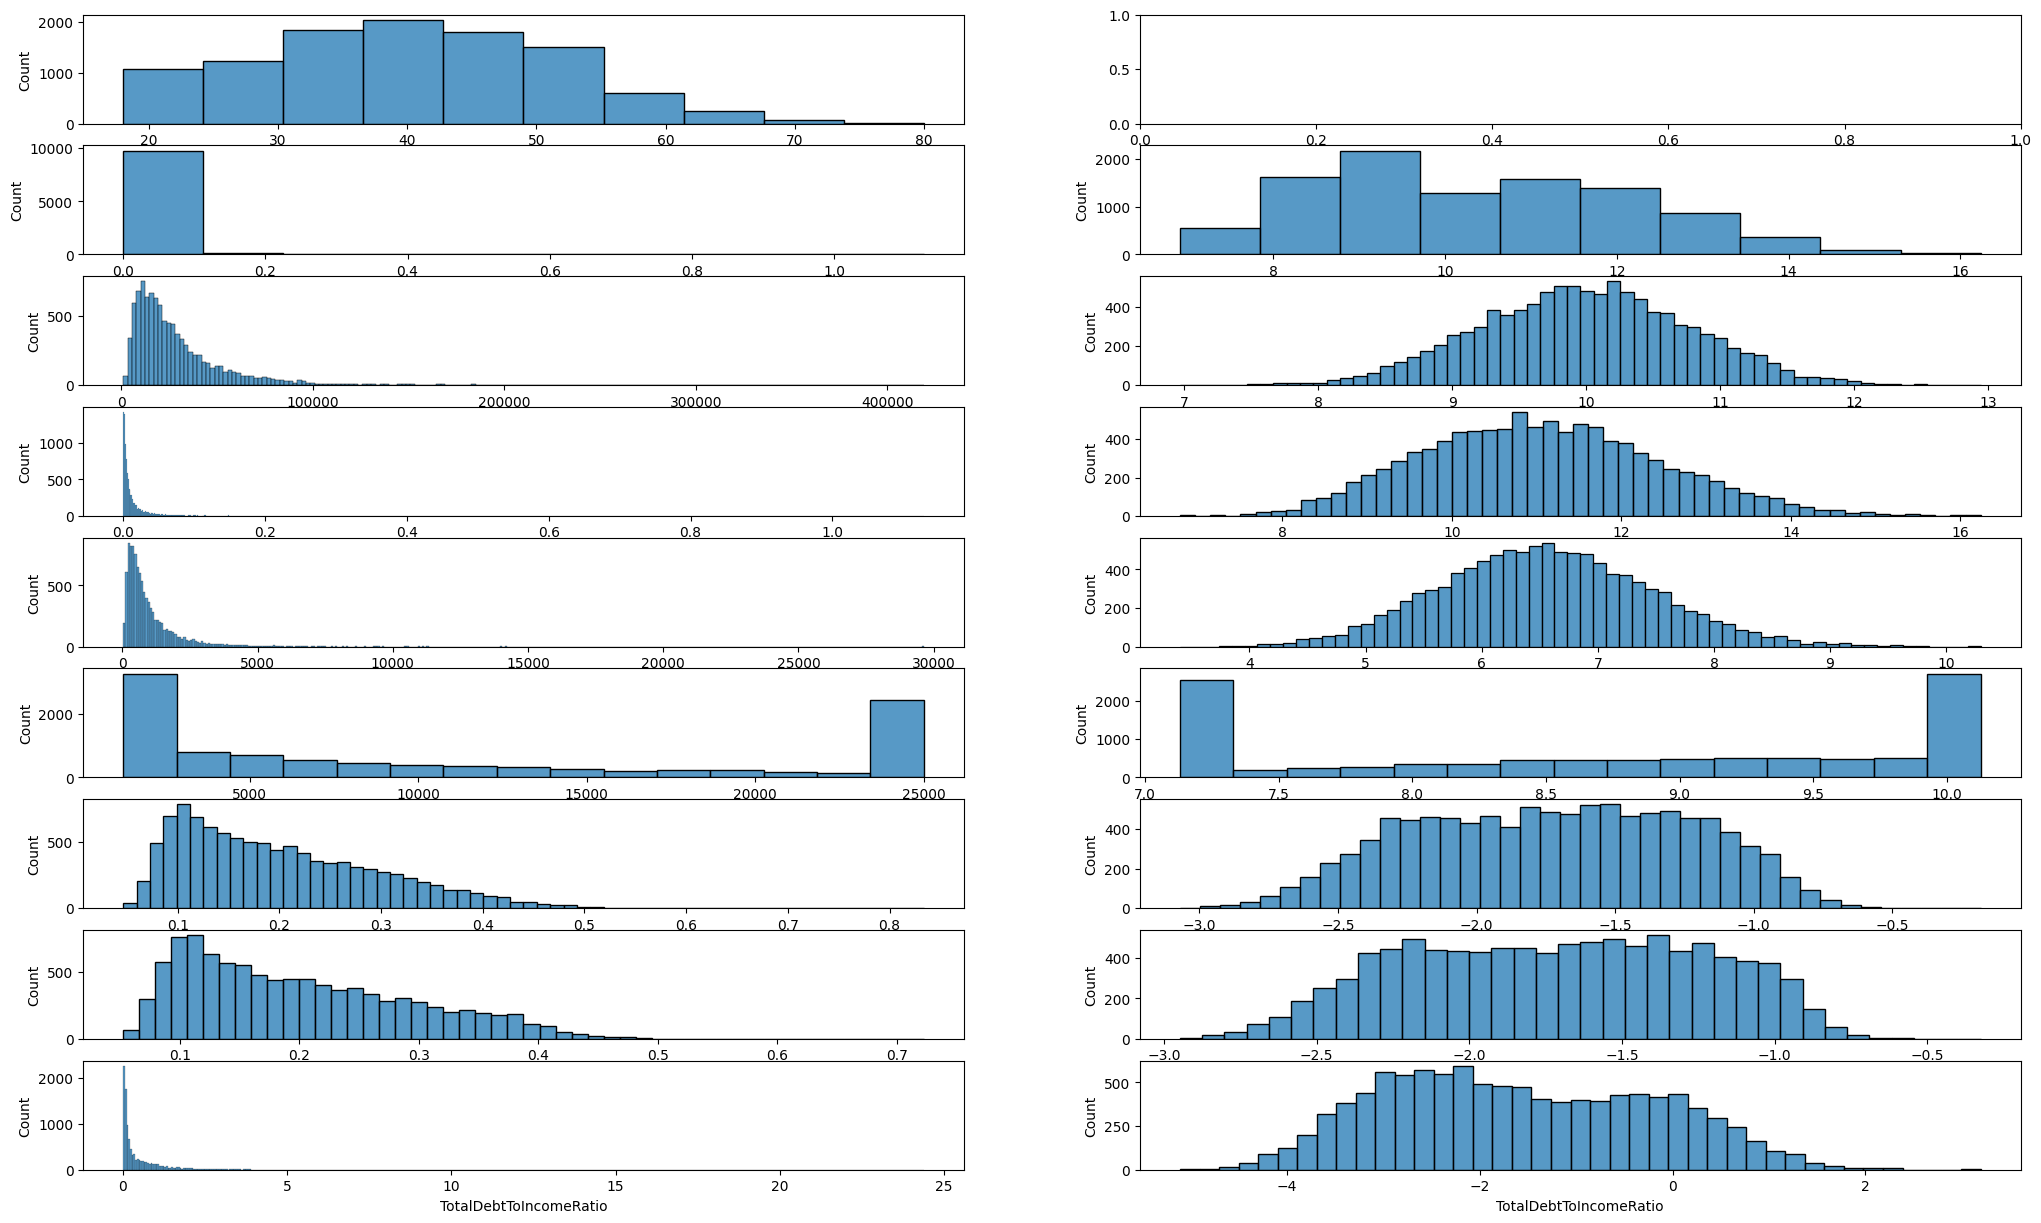

In [40]:
fig, axes = plt.subplots(9, 2, figsize=(25, 15))
sns.histplot(train['Age'], bins=10, ax=axes[0, 0])

sns.histplot(train['NetWorth'], ax=axes[1, 0], bins=10)
sns.histplot(np.log(train['NetWorth']), ax=axes[1, 1], bins=10)

sns.histplot(train['LoanAmount'], ax=axes[2, 0])
sns.histplot(np.log(train['LoanAmount']), ax=axes[2, 1])

sns.histplot(train['TotalAssets'], ax=axes[3, 0])
sns.histplot(np.log(train['TotalAssets']), ax=axes[3, 1])

sns.histplot(train['MonthlyLoanPayment'], ax=axes[4, 0])
sns.histplot(np.log(train['MonthlyLoanPayment']), ax=axes[4, 1])

sns.histplot(train['MonthlyIncome'], ax=axes[5, 0])
sns.histplot(np.log(train['MonthlyIncome']), ax=axes[5, 1])

sns.histplot(train['InterestRate'], ax=axes[6, 0])
sns.histplot(np.log(train['InterestRate']), ax=axes[6, 1])

sns.histplot(train['BaseInterestRate'], ax=axes[7, 0])
sns.histplot(np.log(train['BaseInterestRate']), ax=axes[7, 1])

sns.histplot(train['TotalDebtToIncomeRatio'], ax=axes[8, 0])
sns.histplot(np.log(train['TotalDebtToIncomeRatio']), ax=axes[8, 1])

In [41]:
def process_features_and_interactions(df_train, df_test, y, top_k=40):
    df_train = df_train.reset_index(drop=True).copy()
    df_test = df_test.reset_index(drop=True).copy()
    y = y.reset_index(drop=True)
    
    train_len = len(df_train)
    all_data = pd.concat([df_train, df_test], axis=0, ignore_index=True)
    
    if 'CreditScore' in all_data.columns:
        bins = [-np.inf, 300, 500, 600, 650, 700, 750, 800, 850, 900, np.inf]
        
        all_data['CS_Bin'] = pd.cut(all_data['CreditScore'], bins=bins, labels=False)
        all_data = pd.get_dummies(all_data, columns=['CS_Bin'], prefix='CS_Range')

    
    numeric_cols = all_data.select_dtypes(include=[np.number]).columns.drop('ID', errors='ignore')
    cols_to_transform = [c for c in numeric_cols if all_data[c].nunique() > 10 and 'CS_Range' not in c]

    for col in cols_to_transform:
        val = all_data[col].fillna(all_data[col].median())
        
        all_data[f'Log_{col}'] = np.log1p(val.clip(lower=0))
        all_data[f'Sqrt_{col}'] = np.sqrt(val.clip(lower=0))

    df_train_proc = all_data.iloc[:train_len].copy().reset_index(drop=True)
    df_test_proc = all_data.iloc[train_len:].copy().reset_index(drop=True)

    df_temp = df_train_proc.select_dtypes(include=[np.number]).copy()
    df_temp['target'] = y
    
    corrs = df_temp.corrwith(df_temp['target']).abs().sort_values(ascending=False)
    
    interaction_features = corrs.drop('target', errors='ignore').head(top_k).index.tolist()

    
    poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)
    
    X_train_poly = poly.fit_transform(df_train_proc[interaction_features].fillna(0))
    X_test_poly = poly.transform(df_test_proc[interaction_features].fillna(0))
    
    poly_cols = poly.get_feature_names_out(interaction_features)
    
    df_train_poly = pd.DataFrame(X_train_poly, columns=poly_cols, index=df_train_proc.index)
    df_test_poly = pd.DataFrame(X_test_poly, columns=poly_cols, index=df_test_proc.index)
    
    new_poly_cols = [c for c in poly_cols if c not in df_train_proc.columns]
    df_train_poly = df_train_poly[new_poly_cols]
    df_test_poly = df_test_poly[new_poly_cols]

    def clip_div(a, b):
        res = np.divide(a, b, out=np.zeros_like(a), where=np.abs(b) > 1e-3)
        
        return np.clip(res, -1e4, 1e4)

    new_cols_train = []
    new_cols_test = []
    
    for i, col1 in enumerate(interaction_features):
        for col2 in interaction_features[i+1:]:
            name_div = f'{col1}_div_{col2}'
            new_cols_train.append(pd.Series(clip_div(df_train_proc[col1].values, df_train_proc[col2].values), name=name_div))
            new_cols_test.append(pd.Series(clip_div(df_test_proc[col1].values, df_test_proc[col2].values), name=name_div))

            name_diff = f'{col1}_minus_{col2}'
            new_cols_train.append(pd.Series(df_train_proc[col1].values - df_train_proc[col2].values, name=name_diff))
            new_cols_test.append(pd.Series(df_test_proc[col1].values - df_test_proc[col2].values, name=name_diff))

    X_tr = pd.concat([df_train_proc, df_train_poly] + new_cols_train, axis=1)
    X_ts = pd.concat([df_test_proc, df_test_poly] + new_cols_test, axis=1)
    
    X_tr = X_tr.loc[:, ~X_tr.columns.duplicated()]
    X_ts = X_ts.loc[:, ~X_ts.columns.duplicated()]
    
    missing_cols = set(X_tr.columns) - set(X_ts.columns)
    for c in missing_cols:
        X_ts[c] = 0
        
    X_ts = X_ts[X_tr.columns]

    X_tr = X_tr.replace([np.inf, -np.inf], 0).fillna(0)
    X_ts = X_ts.replace([np.inf, -np.inf], 0).fillna(0)

    numeric_columns = X_tr.select_dtypes(include=[np.number]).columns
    
    for col in numeric_columns:
        if X_tr[col].nunique() < 5: 
            continue
            
        lower = np.percentile(X_tr[col], 1)
        upper = np.percentile(X_tr[col], 99)
        
        X_tr[col] = np.clip(X_tr[col], lower, upper)
        X_ts[col] = np.clip(X_ts[col], lower, upper)
    
    const_cols = [c for c in X_tr.columns if X_tr[c].std() == 0]
    X_tr.drop(columns=const_cols, inplace=True)
    X_ts.drop(columns=const_cols, inplace=True)

    print(f"Final feature count: {X_tr.shape[1]}")
    
    return X_tr, X_ts

In [42]:
y_train = train_clean['RiskScore'].astype(float)
X_train_raw = train_clean.drop('RiskScore', axis=1).astype(float)
X_test_raw = test_clean.copy().astype(float)

X_train, X_test = process_features_and_interactions(X_train_raw, X_test_raw, y_train, top_k=50)

mean = X_train.mean()
std = X_train.std()
std = std.replace(0, 1)
X_train_norm = (X_train - mean) / std
X_test_norm = (X_test - mean) / std

X_train_np = X_train_norm.values.astype(float)
X_test_np = X_test_norm.values.astype(float)
y_train_np = y_train.values.astype(float)

Final feature count: 3804


Обучение на 3804 признаках...
Final loss: 0
Number of iterations: 1
MSE на тренировочной выборке: 22.0948


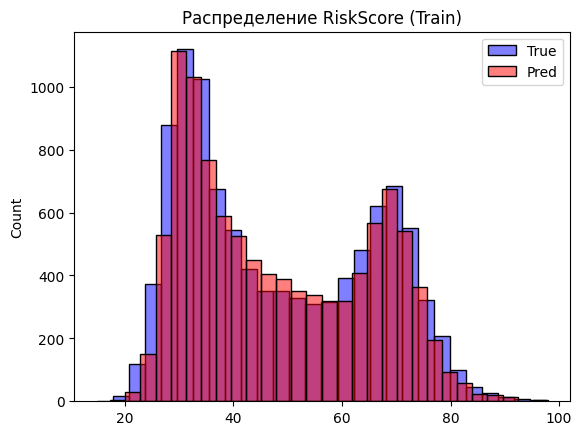

In [43]:
solver = ExactSolver(alpha=20)

model = LinearRegression(solver=solver, verbose=True)

print(f"Обучение на {X_train_np.shape[1]} признаках...")
model.fit(X_train_np, y_train_np)

train_predictions = model.predict(X_train_np)

mse_train = MSE().score(y_train_np, train_predictions)
print(f"MSE на тренировочной выборке: {mse_train:.4f}")

sns.histplot(y_train_np, color='blue', alpha=0.5, label='True')
sns.histplot(train_predictions, color='red', alpha=0.5, label='Pred')
plt.title("Распределение RiskScore (Train)")
plt.legend()
plt.show()

In [44]:
test_predictions = model.predict(X_test_np)

submission = pd.DataFrame({
    'ID': test_ids,
    'RiskScore': test_predictions
})

submission['RiskScore'] = submission['RiskScore']

submission.to_csv('submission.csv', index=False)
print("Файл submission.csv сохранен.")
print(submission.head(20))

Файл submission.csv сохранен.
    ID  RiskScore
0    0  33.485587
1    1  53.311795
2    2  29.007369
3    3  33.543368
4    4  33.564606
5    5  70.082906
6    6  30.452770
7    7  30.872826
8    8  37.716734
9    9  67.074339
10  10  32.682324
11  11  28.812148
12  12  70.209805
13  13  34.329828
14  14  34.453033
15  15  58.421788
16  16  23.480620
17  17  29.603315
18  18  63.301139
19  19  69.445408


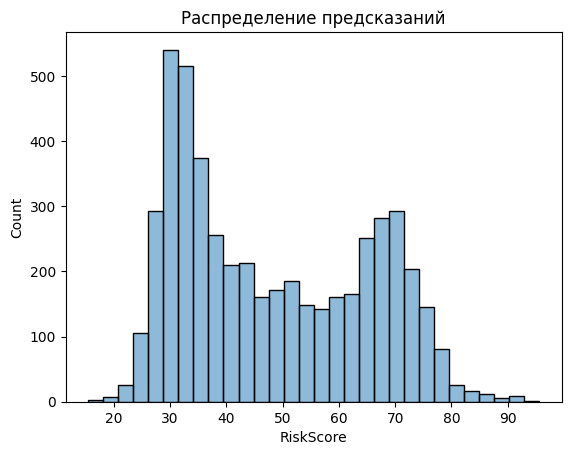

In [45]:
sns.histplot(submission['RiskScore'], bins=30, alpha=0.5)
plt.title("Распределение предсказаний")
plt.show()

In [46]:
submission.describe()

,ID,RiskScore
count,5000.000000,5000.000000
mean,2499.500000,48.121879
std,1443.520003,16.706164
min,0.000000,15.439968
25%,1249.750000,32.808375
50%,2499.500000,44.303195
75%,3749.250000,64.369013
max,4999.000000,95.571322
